# Sentiment classification - close to the state of the art

- The task of classifying sentiments of texts (for example movie or product reviews) has high practical significance in online marketing as well as financial prediction. This is a non-trivial task, since the concept of sentiment is not easily captured.

- For this assignment you have to use the larger [IMDB sentiment](https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz) benchmark dataset from Stanford, an achieve close to state of the art results.


The task is to try out multiple models in ascending complexity, namely:

1. TFIDF + classical statistical model 
    - Random Forest 
    - Naive Bias
2. LSTM classification model
    - Untuned 
    - Tuning using the Keras-Tuning
3. LSTM model, where the embeddings are initialized with pre-trained word vectors
    - GLOVE Embedding - Wiki 2014 dump
    - GLOVE Embedding - Twitter Data
4. fastText model - From facebook


# Data download

In [1]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xzf aclImdb_v1.tar.gz
!ls

--2022-12-23 12:07:29--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  70.8MB/s    in 1.1s    

2022-12-23 12:07:30 (70.8 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]

aclImdb  aclImdb_v1.tar.gz  sample_data


# Alternative with tf.datasets

In [2]:
!pip install tensorflow-datasets > /dev/null

In [ ]:
!pip install spacy
!pip install keras-tuner --upgrade


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import spacy

#model
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import fasttext

from wordcloud import WordCloud
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Input
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import naive_bayes
from keras.callbacks import EarlyStopping

from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from tqdm import tqdm


In [5]:
# Connecting to the google drive to save the temporary files for the execution
from google.colab import drive
drive.mount('/content/drive')
from IPython.display import clear_output

Mounted at /content/drive


In [6]:
(ds_train,ds_test),ds_info = tfds.load(
    name="imdb_reviews",
    split=["train","test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteNQ8COU/imdb_reviews-train.tfrecord*...…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteNQ8COU/imdb_reviews-test.tfrecord*...:…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteNQ8COU/imdb_reviews-unsupervised.tfrec…

Dataset imdb_reviews downloaded and prepared to ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [7]:
ds_info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset.
    This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_path='~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0',
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=25000, num_shards=1>,
        '

In [8]:
type(ds_train)


tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [ ]:


[(train_features, label_batch)] = ds_train.take(1)
print(np.array(train_features))

# Data Extraction 

Converting the tensor dataset into a pandas dataframe for further operations

In [9]:
# didn't realise there is an function as_dataframe, below functions also works
def tensors_to_pandas(df):
  cleaned_Text = []
  label_Text = []
  for train_features, label_batch in  df.take(len(df)):
    cleaned_Text.append(train_features.numpy().decode('utf-8'))
    label_Text.append(label_batch.numpy())


  pandas_df = pd.DataFrame(columns=['Text','Label'])
  pandas_df['Text'] = cleaned_Text
  pandas_df['Label'] = label_Text
  return pandas_df

In [10]:
train_df = tensors_to_pandas(ds_train)
test_df = tensors_to_pandas(ds_test)

In [11]:
train_df.head()

,Text,Label
0,This was an absolutely terrible movie. Don't b...,0
1,"I have been known to fall asleep during films,...",0
2,Mann photographs the Alberta Rocky Mountains i...,0
3,This is the kind of film for a snowy Sunday af...,1
4,"As others have mentioned, all the women that g...",1


In [12]:
train_df.shape

(25000, 2)

In [13]:
test_df.head()

,Text,Label
0,There are films that make careers. For George ...,1
1,"A blackly comic tale of a down-trodden priest,...",1
2,"Scary Movie 1-4, Epic Movie, Date Movie, Meet ...",0
3,Poor Shirley MacLaine tries hard to lend some ...,0
4,As a former Erasmus student I enjoyed this fil...,1


In [14]:
test_df.shape

(25000, 2)

In [15]:
train_df['Label'].value_counts()

0    12500
1    12500
Name: Label, dtype: int64

In [16]:
test_df['Label'].value_counts()

1    12500
0    12500
Name: Label, dtype: int64

The Train and test datasets are equally split. Each dataset same number of  positive and negative reviews with 

## Word Cloud Pre cleaning

- Ploting the World cloud of the uncleaned text data.

In [ ]:

def do_wordcloud(text):
    
    # lower max_font_size
    wordcloud = WordCloud(max_font_size=40, max_words=50).generate(text)
    plt.figure(figsize=(15, 10))
    
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


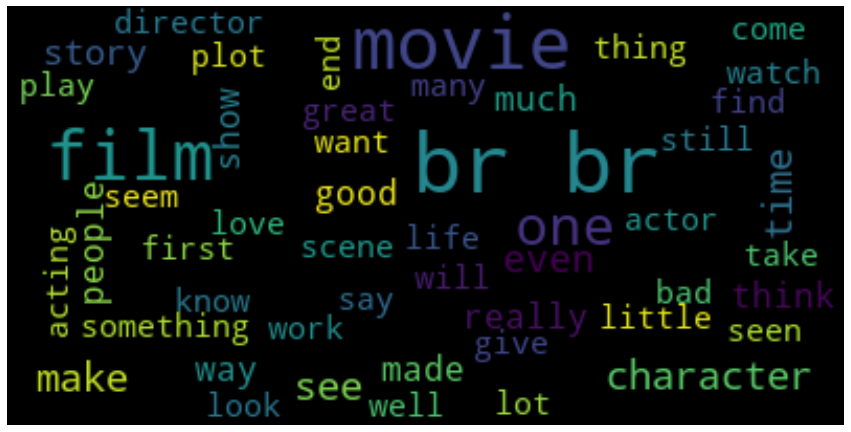

In [ ]:
#Plotting world cloud! for all the train text
main_str = train_df['Text'].str.cat(sep=' ')

do_wordcloud(main_str)



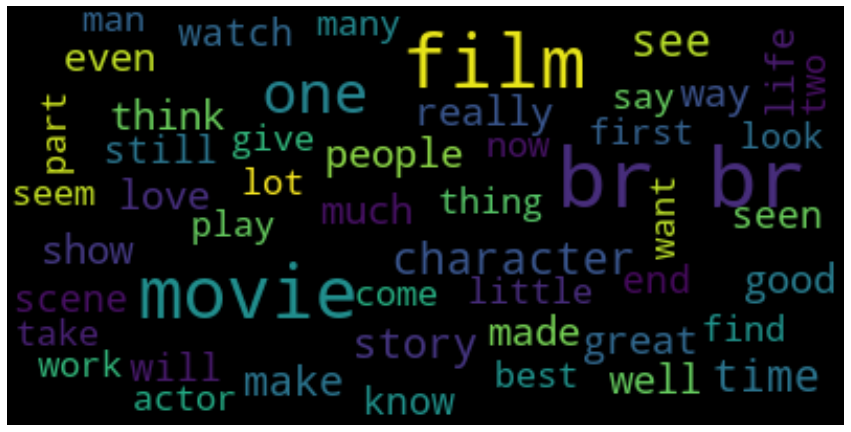

In [ ]:
#Plotting world cloud! for all the train text
main_str = train_df['Text'][train_df['Label']==1].str.cat(sep=' ')

do_wordcloud(main_str)



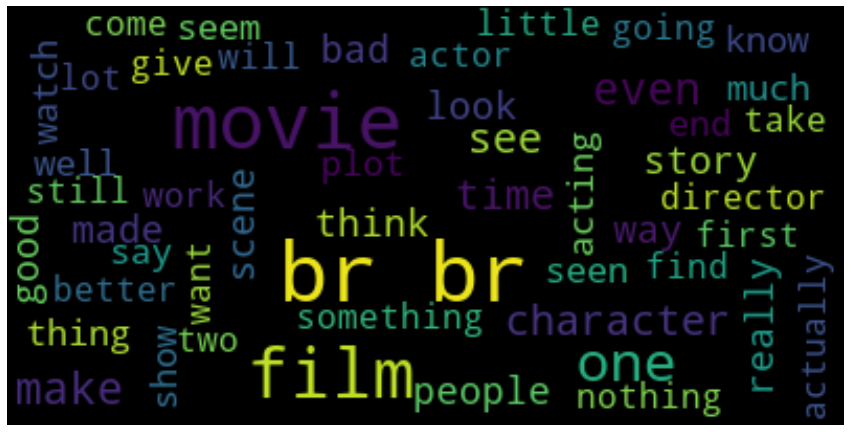

In [ ]:
#Plotting world cloud! for all the train text
main_str = train_df['Text'][train_df['Label']==0].str.cat(sep=' ')
do_wordcloud(main_str)


- From the world cloud one good observation is removing the stopwords might help for the classical models

## Extracting the sentence count 

In [ ]:

train_df['Text'].head().str.split(' ')

0    [This, was, an, absolutely, terrible, movie., ...
1    [I, have, been, known, to, fall, asleep, durin...
2    [Mann, photographs, the, Alberta, Rocky, Mount...
3    [This, is, the, kind, of, film, for, a, snowy,...
4    [As, others, have, mentioned,, all, the, women...
Name: Text, dtype: object

In [ ]:
train_df['uncleaned_Text_len'] = train_df['Text'].apply(lambda x: len(x.split(' ')))

In [ ]:
train_df['uncleaned_Text_len'].describe()

count    25000.000000
mean       233.776720
std        173.715418
min         10.000000
25%        127.000000
50%        174.000000
75%        284.000000
max       2470.000000
Name: uncleaned_Text_len, dtype: float64

 - From the stats we can see the average length of the sentence is 233 and max is 2470.

In [ ]:
label_batch.numpy()

0

## Removing the stopwords

Using the spacy for removing the stopwords and puntuactions from the text. 

In [ ]:
#loading the english language small model of spacy
nlp = spacy.load('en_core_web_sm')
spacy_stopwords = nlp.Defaults.stop_words

In [ ]:

train_df['cleaned_text'] = train_df['Text'].apply(lambda x: ' '.join([token.lemma_ for token in nlp(x.lower()) if token.lemma_ not in spacy_stopwords and not token.is_punct]))

In [ ]:
test_df['cleaned_text'] = test_df['Text'].apply(lambda x: ' '.join([token.lemma_ for token in nlp(x.lower()) if token.lemma_ not in spacy_stopwords and not token.is_punct]))

In [ ]:
train_df.head()

In [ ]:
train_df['cleaned_Text_len'] = train_df['cleaned_text'].apply(lambda x: len(x.split(' ')))

In [ ]:
train_df['cleaned_Text_len'].describe()

- The main intention to calculate the mean number of words in a sentence is to understand what should be the max_length for the LSTM models and using around 120 word length makes more sense when we are using cleaned word list.

In [ ]:
# Saving the cleaned file personal Google drive
path = "/content/drive/MyDrive/NLP_FS_Assignments_2022/Final_assignment/"
train_df.to_csv(path + "train.csv", index=None)
test_df.to_csv(path + "test.csv", index=None)

In [17]:
# laoding the processed file from the drive.
path = "/content/drive/MyDrive/NLP_FS_Assignments_2022/Final_assignment/"
train_df = pd.read_csv(path + "train.csv")

test_df = pd.read_csv(path + "test.csv")


In [ ]:
train_df.head(2)

- Model Building: 

With every algorithm I have used the train_df as the training dataset while test_df has been used as out of sample dataset for validation. For each algorithm trained I have printed the Confusion matix and classification report.

# 1. TFIDF + Stats algorithm

## 1.1 TFIDF + Random Forest

In [32]:
#TFIDF Vectorizer
tfidfvectorizer = TfidfVectorizer(max_features = 100000, ngram_range = (1,2), analyzer='word',stop_words= 'english')

In [33]:
tfidf_wm = tfidfvectorizer.fit_transform(train_df['Text'])

In [34]:
tfidf_tokens = tfidfvectorizer.get_feature_names()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [35]:
tfidf_test = tfidfvectorizer.transform(test_df['Text'])

In [36]:
#loading the Random forest and fitting with the data
classifier = RandomForestClassifier()

classifier.fit(tfidf_wm, train_df['Label'])

RandomForestClassifier()

In [37]:
y_pred = classifier.predict(tfidf_test)

In [38]:

print(classification_report(test_df['Label'],y_pred))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85     12500
           1       0.86      0.84      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



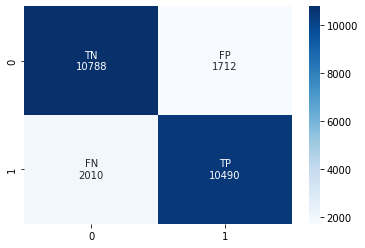

In [39]:

cnf_matrix = confusion_matrix(test_df['Label'],y_pred)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues');

In [31]:
tfidf_wm.shape

(25000, 74538)

### Motivation and Observations: 

- Random forest is more of baseline algorthm. Using TF- IDF I have created columns which are unique words from the whole training corpus. This is more frequentist approach where we not concerned about the sequence of the words. Random forest is good at identifying the Important features which in this case the important unique words in classifying the sentiment. The metrics will be used as baseline for other models.

## 1.2 using Naive Bayes Model 

In [40]:
clf = naive_bayes.MultinomialNB()

In [41]:
model=clf.fit(tfidf_wm, train_df['Label'])

In [42]:
y_pred = model.predict(tfidf_test)

In [43]:
print(classification_report(test_df['Label'],y_pred))

              precision    recall  f1-score   support

           0       0.83      0.88      0.86     12500
           1       0.88      0.83      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.86      0.85      0.85     25000
weighted avg       0.86      0.85      0.85     25000



### Motivation and Observations: 

- Naive Bayes is where we are trying the bayesian approach . That we are assuming the featres are conditional independent given class variable. Using MultinomialNB we are doing a relative frequencey counting for each feature. 

Observation is this model performes as good as the Random forest.

# 2. LSTM classification model

## 2.1 Data merging and tokenizing
Lets join both datasets and tokensize as a whole

In [ ]:
final_df = pd.concat([train_df[['cleaned_text', 'Label']], test_df[['cleaned_text', 'Label']]])

In [ ]:
final_df.reset_index(drop=True, inplace=True)

In [ ]:
final_df.head()

,cleaned_text,Label
0,absolutely terrible movie lure christopher wal...,0
1,I know fall asleep film usually combination th...,0
2,mann photograph alberta rocky mountain superb ...,0
3,kind film snowy sunday afternoon rest world ah...,1
4,mention woman nude film absolutely gorgeous pl...,1


Process the data
- Tokenize the data and convert the text to sequences.
- Add padding to ensure that sequence which are less than max_length are filled with padding token.
- There are many ways of taking the max_len and here an arbitrary length of 150 is chosen.

## 2.2 LSTM Untuned

First we will build an untuned version of the model and see how the results are 

In [ ]:
# max_words = 40000
max_len = 120  # cut texts after this number of words

In [ ]:
# Tokenising data that is converting the sentence into vector form.
tok = Tokenizer()
tok.fit_on_texts(final_df['cleaned_text'].values)
sequences = tok.texts_to_sequences(final_df['cleaned_text'])

# adding padding at the end if teh sentence is less than max_len
sequences_matrix = pad_sequences(sequences,padding='post', maxlen=max_len)


In [ ]:
# Assigning the coval size based on the words count 
vocab_size = len(tok.word_index)+1

In [ ]:
vocab_size

92101

In [ ]:
# just curious how the tokenied and padded vector looks like
sequences_matrix[3]

array([   96,     4,  7796,  2246,  2263,   214,    62,  1165,   716,
        4254,    47,  1136,  2194, 12820,   196,   156,   242,    44,
        7089,  5577,  1673,  7546,  2453,    28,  5120,   953,  1411,
         572,  1521,  1540, 18196,    52,   633,    27,     6,    86,
           4,   125,   363,  1443,   868,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0], dtype=int32)

In [ ]:
sequences_matrix_train = sequences_matrix[:25000]
sequences_matrix_test = sequences_matrix[25000:]

In [ ]:
sequences_matrix_train.shape, sequences_matrix_test.shape

((25000, 120), (25000, 120))

In [ ]:
# Building the RNN model

embedding_vector_features=300

# Intializing the Keras Model 
model=Sequential()

# intializing input layer with max length as the input
model.add(Input(name='inputs',shape=[max_len]))

# Creating the input layer where the inpiut_dim is vocabulary Size , 
# Embedding is set to 300 and since each input vector is of size 120 length.
model.add(Embedding(vocab_size, embedding_vector_features, input_length=max_len))

# setting the LSTM layer with 256
model.add(LSTM(128))

# Since we are using label column without one hot encoded we are using the dense 
# layer as 1 and activation function as sigmoid
model.add(Dense(1,activation='sigmoid'))

# AS it is a Binary classification problem using binary_crossentropy
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 300)          27630300  
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 27,850,077
Trainable params: 27,850,077
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Fitting the model by taking basic parameter combination.
model.fit(sequences_matrix_train, train_df['Label'].values,
          
          epochs=20,
          batch_size=32
          # callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.00001)] # Not required The training process is super fast
        )

Epoch 1/20
782/782 [==============================] - 26s 24ms/step - loss: 0.6370 - accuracy: 0.6182
Epoch 2/20
782/782 [==============================] - 19s 24ms/step - loss: 0.3673 - accuracy: 0.8413
Epoch 3/20
782/782 [==============================] - 19s 24ms/step - loss: 0.1767 - accuracy: 0.9373
Epoch 4/20
782/782 [==============================] - 19s 24ms/step - loss: 0.0909 - accuracy: 0.9728
Epoch 5/20
782/782 [==============================] - 20s 26ms/step - loss: 0.0604 - accuracy: 0.9832
Epoch 6/20
782/782 [==============================] - 19s 24ms/step - loss: 0.0333 - accuracy: 0.9913
Epoch 7/20
782/782 [==============================] - 19s 24ms/step - loss: 0.0203 - accuracy: 0.9958
Epoch 8/20
782/782 [==============================] - 19s 24ms/step - loss: 0.0126 - accuracy: 0.9978
Epoch 9/20
782/782 [==============================] - 19s 24ms/step - loss: 0.0104 - accuracy: 0.9981
Epoch 10/20
782/782 [==============================] - 19s 24ms/step - loss: 0.009

In [ ]:
model.evaluate(sequences_matrix_test, test_df['Label'].values, verbose=False)

[1.2801120281219482, 0.8124399781227112]

In [ ]:
predict_values = model.predict(sequences_matrix_test)

782/782 [==============================] - 4s 4ms/step


In [ ]:

predict_values[predict_values>0.5]=1 
predict_values[predict_values<=0.5]=0 

In [ ]:
# Printing the classification report
print(classification_report(test_df['Label'],predict_values))

              precision    recall  f1-score   support

           0       0.84      0.77      0.80     12500
           1       0.79      0.85      0.82     12500

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000



### Analysis Points
The LSTM model is underperforming than the previous models and we should tune it increase the perfomance by not overfitting the model.

## 2.3 LSTM Tuned 

- Tuning the model using the Keras tuner 

In [ ]:
def build_model(hp):
    # Building the RNN model
    # Intializing the Keras Model 
    model=Sequential()

    # intializing input layer with max length as the input
    model.add(Input(name='inputs',shape=[max_len]))

    # Creating the input layer where the inpiut_dim is vocabulary Size , 
    # Embedding is set to hyper parametering and since each input vector is of size 120 length.
    model.add(Embedding(vocab_size, hp.Int('Embedding_unit',min_value=32,max_value=512,step=32), input_length=max_len))

    # setting the LSTM layer with 256
    model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=256,step=32)))

    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    # Since we are using label column without one hot encoded we are using the dense 
    # layer as 1 and activation function as sigmoid
    model.add(Dense(1,activation='sigmoid'))

    # AS it is a Binary classification problem using binary_crossentropy
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


    return model

In [ ]:
# Here we are assigning the Objective, max trails for how the model should be trained
tuner= RandomSearch(
        build_model, # The Model used for training
        objective=['accuracy'], # The metric that we want to optimse
        max_trials=12, # Max number of combination trails to be used
        executions_per_trial=1 # Each Combinaiton might give u different
                            # results but in this case we are restricting one combination one time 
                                                    
        )

- As an extra step I placing the last 2000 records of the train as validaiton set

In [ ]:
sequences_matrix.shape

(50000, 120)

In [ ]:
# Dividing the features data into Train , Test and Valid
sequences_matrix_train = sequences_matrix[:23000]
sequences_matrix_valid = sequences_matrix[23000:25000]
sequences_matrix_test = sequences_matrix[25000:]

In [ ]:
# Dividing the Target Train into Train and Valid
train_target = train_df['Label'][:23000]
valid_target = train_df['Label'][23000:25000]


train_target.shape , valid_target.shape

((23000,), (2000,))

In [ ]:
# Configuring the tuner with the size of X & y , epochs etc
tuner.search(
        x=sequences_matrix_train,
        y=train_target,
        epochs=15,
        batch_size=128,
        validation_data=(sequences_matrix_valid,valid_target),
)

Trial 12 Complete [00h 00m 48s]
multi_objective: -0.9906956553459167

Best multi_objective So Far: -0.9982608556747437
Total elapsed time: 00h 13m 07s


In [ ]:
#Extracting the best results from the search
best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 384)          35366784  
                                                                 
 lstm (LSTM)                 (None, 256)               656384    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 36,023,425
Trainable params: 36,023,425
Non-trainable params: 0
_________________________________________________________________


In [ ]:
sequences_matrix_train.shape, sequences_matrix_test.shape

((23000, 120), (25000, 120))

In [ ]:
# Prediciton And printing the results
predict_values = best_model.predict(sequences_matrix_test)

predict_values[predict_values>0.5]=1 
predict_values[predict_values<=0.5]=0 


# Printing the classification report
print(classification_report(test_df['Label'],predict_values))

782/782 [==============================] - 4s 5ms/step
              precision    recall  f1-score   support

           0       0.82      0.84      0.83     12500
           1       0.83      0.82      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



### Motivation and Observations.

- LSTM is a Neural Netweok Model which gives more advantages over the classic methods (like random Forest). The long term memory helps to sort of capture the contect of the words. Some times reviews are not summarised in one word but stated as phrases or sentences. Imagine a user gaves a 7 sentence it is required to understand what are his views from 1st to last sentence and LSTM long term memory & Short term memory are effective in capturing that.

- Also When we are using words as features the number will increase LSTM will be more effective in handling.

- The tuned model is doing better than untuned by 2 percent but still not as good as the random forest model from the TFIDF models. 


# 3. LSTM + Pretrained Embedding

## 3.1 LSTM model + Glove  
where the embeddings are initialized with pre-trained word vectors Wikipedia 2014 + Gigaword 5

In [ ]:
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip 

--2022-12-22 16:14:15--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2022-12-22 16:14:15--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2022-12-22 16:14:16--  https://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/

In [ ]:
!unzip glove*.zip

Archive:  glove.840B.300d.zip
  inflating: glove.840B.300d.txt     


In [ ]:
!ls
!pwd

'~'		     fasttext		   IMDB_DATA.txt      v0.9.2.zip
 aclImdb	     fastText-0.9.2	   imdb.train
 aclImdb_v1.tar.gz   glove.840B.300d.txt   sample_data
 drive		     glove.840B.300d.zip   untitled_project
/content


In [ ]:
#Extracting the embedding Vector from the text file
embedding_vector = {}
f = open('../content/glove.840B.300d.txt')
for line in tqdm(f):
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:],dtype = 'float32')
    embedding_vector[word] = coef

2196017it [01:46, 20650.13it/s]


In [ ]:
# Tokenising data that is converting the sentence into vector form.
max_len = 120
tok = Tokenizer()
tok.fit_on_texts(final_df['cleaned_text'].values)
sequences = tok.texts_to_sequences(final_df['cleaned_text'])

# adding padding at the end if the sentence is less than max_len
sequences_matrix = pad_sequences(sequences,padding='post', maxlen=max_len)


In [ ]:
# Dividing the features data into Train , Test and Valid
sequences_matrix_train = sequences_matrix[:23000]
sequences_matrix_valid = sequences_matrix[23000:25000]
sequences_matrix_test = sequences_matrix[25000:]

In [ ]:
# Dividing the Target Train into Train and Valid
train_target = train_df['Label'][:23000]
valid_target = train_df['Label'][23000:25000]


train_target.shape , valid_target.shape

((23000,), (2000,))

In [ ]:
# Assigning the coval size based on the words count 
vocab_size = len(tok.word_index)+1

In [ ]:
vocab_size

92101

In [ ]:
# creating the matrix with zeros where we are defining the dimensions based on 
# the vocabuary size and the max words previously assigned.
max_words= 300
embedding_matrix = np.zeros((vocab_size,max_words))

# Basically for each unique word in the tokeniser we are getting the embdedding 
# vector and consolidating the vectors in the embedding_matrix, basically it will be 
# lookup table.

for word,i in tqdm(tok.word_index.items()):
   # Words not found in embedding index will be all-zeros.
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

100%|██████████| 92100/92100 [00:00<00:00, 409173.52it/s]


In [ ]:
embedding_matrix.shape

(92101, 300)

In [ ]:
embedding_vector_features=300

# Intializing the Keras Model 
model=Sequential()


# In this model when we compare to the previous model,new paramater called weights are 
# added which has the pretained weights from the GLOVE, embedding_vector_features
# is to GLOVE vector size and rest almost remains same.
# trainable=False to avoid updating the pretrained weights

model.add(Embedding(vocab_size,                    
                    embedding_vector_features, 
                    weights=[embedding_matrix],
                    input_length=max_len,
                    trainable=False))



model.add(LSTM(128))

model.add(Dropout(0.02))

# Since we are using label column without one hot encoded we are using the dense 
# layer as 1 and activation function as sigmoid
model.add(Dense(1,activation='sigmoid'))

# AS it is a Binary classification problem using binary_crossentropy
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 120, 300)          27630300  
                                                                 
 lstm_3 (LSTM)               (None, 128)               219648    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 27,850,077
Trainable params: 219,777
Non-trainable params: 27,630,300
_________________________________________________________________
None


In [ ]:
#Just to make sure no overlapping
sequences_matrix.shape, sequences_matrix_train.shape, sequences_matrix_valid.shape, sequences_matrix_test.shape

((50000, 120), (23000, 120), (2000, 120), (25000, 120))

In [ ]:
# Fitting the model
history = model.fit(sequences_matrix_train, train_target,
          
          epochs=25,
          batch_size=32,
          validation_data=(sequences_matrix_valid,valid_target),
          callbacks=[EarlyStopping(monitor='val_accuracy', baseline=0.92, patience=25)]
          )

Epoch 1/25
719/719 [==============================] - 10s 11ms/step - loss: 0.5823 - accuracy: 0.7082 - val_loss: 0.4222 - val_accuracy: 0.8150
Epoch 2/25
719/719 [==============================] - 9s 12ms/step - loss: 0.3816 - accuracy: 0.8385 - val_loss: 0.3569 - val_accuracy: 0.8500
Epoch 3/25
719/719 [==============================] - 10s 14ms/step - loss: 0.3230 - accuracy: 0.8642 - val_loss: 0.3243 - val_accuracy: 0.8675
Epoch 4/25
719/719 [==============================] - 7s 10ms/step - loss: 0.2938 - accuracy: 0.8793 - val_loss: 0.3226 - val_accuracy: 0.8590
Epoch 5/25
719/719 [==============================] - 7s 10ms/step - loss: 0.2686 - accuracy: 0.8899 - val_loss: 0.2983 - val_accuracy: 0.8750
Epoch 6/25
719/719 [==============================] - 7s 10ms/step - loss: 0.2416 - accuracy: 0.9036 - val_loss: 0.3154 - val_accuracy: 0.8670
Epoch 7/25
719/719 [==============================] - 7s 10ms/step - loss: 0.2064 - accuracy: 0.9207 - val_loss: 0.3343 - val_accuracy: 0.85

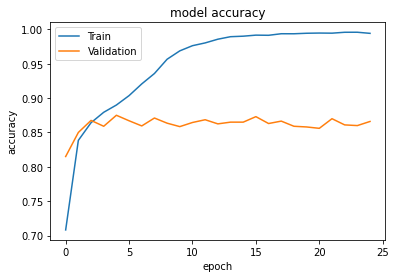

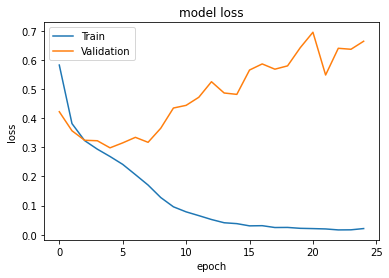

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
predict_values = model.predict(sequences_matrix_test)

782/782 [==============================] - 4s 4ms/step


In [ ]:

predict_values[predict_values>0.5]=1 
predict_values[predict_values<=0.5]=0 

In [ ]:
print(classification_report(test_df['Label'],predict_values))

              precision    recall  f1-score   support

           0       0.89      0.82      0.86     12500
           1       0.84      0.90      0.87     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



### Motivation & Observation :

- All teh good points anout LSTM also apply to this approach. The speciality of this part is we have used an embeddinging from GLoVE. The question I had was to pick Word2vector or GLOVE. I have tried Both GLOVE trained on Wiki & Twitter was well.

- I felt GLove has more suitable for this use case because It uses Gloabl Word - Word Co ocurance matrix approach for calculating the frequency . There are examples like "Good Movie" and "Not Good Movie" Where occurance of "not" before good changes the meaninig of the sentiment. On my analysis W2V performed better at understanding the coontext of the Text

- Coming to the model first thing I observed is model is overfitting after 6th or 7th epochs. But it does better than the models built so far.

## 3.2 LSTM model + Glove Twitter  
where the embeddings are initialized with pre-trained word vectors

### Loading the GLOVE Twitter embdedding

In [ ]:
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip

--2022-12-22 16:45:22--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2022-12-22 16:45:22--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2022-12-22 16:45:23--  https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [ap

In [ ]:
!unzip glove.twitter.27B.zip

Archive:  glove.twitter.27B.zip
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  


In [ ]:
!ls
!pwd

'~'		     glove.840B.300d.txt	  glove.twitter.27B.zip
 aclImdb	     glove.840B.300d.zip	  IMDB_DATA.txt
 aclImdb_v1.tar.gz   glove.twitter.27B.100d.txt   imdb.train
 drive		     glove.twitter.27B.200d.txt   sample_data
 fasttext	     glove.twitter.27B.25d.txt	  untitled_project
 fastText-0.9.2      glove.twitter.27B.50d.txt	  v0.9.2.zip
/content


In [ ]:
#Extracting the embedding Vector from the text file
embedding_vector = {}
f = open('../content/glove.twitter.27B.200d.txt')
for line in tqdm(f):
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:],dtype = 'float32')
    embedding_vector[word] = coef

1193514it [00:44, 26540.78it/s]


In [ ]:
# Tokenising data that is converting the sentence into vector form.
max_len = 120
tok = Tokenizer()
tok.fit_on_texts(final_df['cleaned_text'].values)
sequences = tok.texts_to_sequences(final_df['cleaned_text'])

# adding padding at the end if the sentence is less than max_len
sequences_matrix = pad_sequences(sequences,padding='post', maxlen=max_len)


In [ ]:
# Dividing the tokenised Text data into Train, valid and Test
sequences_matrix_train = sequences_matrix[:23000]
sequences_matrix_valid = sequences_matrix[23000:25000]
sequences_matrix_test = sequences_matrix[25000:]

In [ ]:
# Dividing the target column into Train and valid 
train_target = train_df['Label'][:23000]
valid_target = train_df['Label'][23000:25000]


train_target.shape , valid_target.shape

((23000,), (2000,))

In [ ]:
vocab_size

92101

In [ ]:
# creating the matrix with zeros where we are defining the dimensions based on 
# the vocabuary size and the max words previously assigned.
max_words= 200
embedding_matrix = np.zeros((vocab_size,max_words))

# Basically for each unique word in the tokeniser we are getting the embdedding 
# vector and consolidating the vectors in the embedding_matrix, basically it will be 
# lookup table.

for word,i in tqdm(tok.word_index.items()):
   # Words not found in embedding index will be all-zeros.
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

100%|██████████| 92100/92100 [00:00<00:00, 551469.27it/s]


In [ ]:
embedding_matrix.shape

(92101, 200)

In [ ]:
# Since the Dimentions we have selected is 200 dimentions 
embedding_vector_features=200

# Intializing the Keras Model 
model=Sequential()


# In this model when we compare to the previous model,new paramater called weights are 
# added which has the pretained weights from the GLOVE, embedding_vector_features
# is to GLOVE vector size and rest almost remains same.
# trainable=False to avoid updating the pretrained weights

model.add(Embedding(vocab_size,                    
                    embedding_vector_features, 
                    weights=[embedding_matrix],
                    input_length=max_len,
                    trainable=False))

model.add(LSTM(128))
model.add(Dropout(0.02))

# Since we are using label column without one hot encoded we are using the dense 
# layer as 1 and activation function as sigmoid
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 120, 200)          18420200  
                                                                 
 lstm_4 (LSTM)               (None, 128)               168448    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 18,588,777
Trainable params: 168,577
Non-trainable params: 18,420,200
_________________________________________________________________
None


In [ ]:
sequences_matrix.shape, sequences_matrix_train.shape

((50000, 120), (23000, 120))

In [ ]:
#Fitting the model

history = model.fit(sequences_matrix_train, train_target,          
          epochs=25,
          batch_size=32,
          validation_data=(sequences_matrix_valid,valid_target),
          callbacks=[EarlyStopping(monitor='val_accuracy', baseline=0.92, patience=25)]
          )

Epoch 1/25
719/719 [==============================] - 9s 11ms/step - loss: 0.6537 - accuracy: 0.6061 - val_loss: 0.6911 - val_accuracy: 0.5155
Epoch 2/25
719/719 [==============================] - 7s 10ms/step - loss: 0.6188 - accuracy: 0.6508 - val_loss: 0.6492 - val_accuracy: 0.6160
Epoch 3/25
719/719 [==============================] - 7s 10ms/step - loss: 0.4998 - accuracy: 0.7431 - val_loss: 0.3665 - val_accuracy: 0.8425
Epoch 4/25
719/719 [==============================] - 7s 10ms/step - loss: 0.3602 - accuracy: 0.8433 - val_loss: 0.3437 - val_accuracy: 0.8570
Epoch 5/25
719/719 [==============================] - 7s 10ms/step - loss: 0.3386 - accuracy: 0.8550 - val_loss: 0.3347 - val_accuracy: 0.8570
Epoch 6/25
719/719 [==============================] - 7s 10ms/step - loss: 0.3185 - accuracy: 0.8643 - val_loss: 0.3363 - val_accuracy: 0.8490
Epoch 7/25
719/719 [==============================] - 7s 10ms/step - loss: 0.3035 - accuracy: 0.8727 - val_loss: 0.3283 - val_accuracy: 0.8635

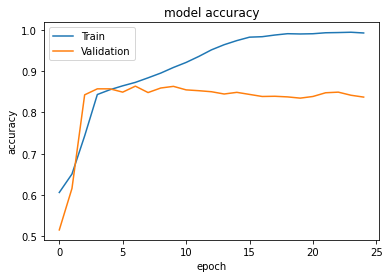

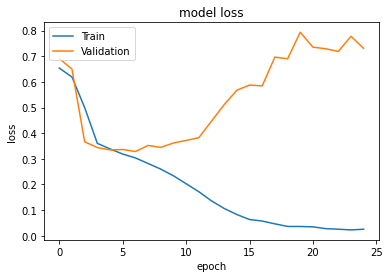

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
predict_values = model.predict(sequences_matrix_test)

782/782 [==============================] - 4s 4ms/step


In [ ]:

predict_values[predict_values>0.5]=1 
predict_values[predict_values<=0.5]=0 

In [ ]:


from sklearn.metrics import confusion_matrix,classification_report
print(classification_report(test_df['Label'],predict_values))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84     12500
           1       0.84      0.83      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



### Motivation:

I was curious if Twitter data can do better than the Wiki data because Tweets often can be about the review of a film, situation , Showing emotions etc. I have trained botht he models on identically like same spochs, same data  and i see Wiki model is performing better.

# 4 FastText model

## 4.1 Downloading and installing FastText

In [ ]:
! wget https://github.com/facebookresearch/fastText/archive/v0.9.2.zip
! unzip v0.9.2.zip

In [ ]:
%cd /content/fastText-0.9.2 
!make
!cp fasttext ../
%cd ..

/content/fastText-0.9.2
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/args.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/autotune.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/matrix.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/dictionary.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/loss.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/productquantizer.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/densematrix.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/quantmatrix.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/vector.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/model.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/utils.cc
c++ -pthread -std=c++11 -march=native -O3 -

In [ ]:
!pip install fasttext

In [ ]:
# The Fast Text Need the data to be in below format i.e with "__label__(label_name) main_text"
train_df['fast_text'] =  train_df['Label'].replace({0:' __label__negative ',1:' __label__positive '}).astype(str) + ' ' + train_df['cleaned_text'] 


In [ ]:
# Just cheking if the conc is working
train_df['fast_text'].head()

0     __label__negative  absolutely terrible movie ...
1     __label__negative  I know fall asleep film us...
2     __label__negative  mann photograph alberta ro...
3     __label__positive  kind film snowy sunday aft...
4     __label__positive  mention woman nude film ab...
Name: fast_text, dtype: object

In [ ]:
# Exporting train file a text file . I guess we can also dump the file as csv
train_df['fast_text'].to_csv(r'IMDB_DATA.txt', header=None, index=None, sep=' ', mode='w')


In [ ]:
train_df['Label'].value_counts(0)

0    12500
1    12500
Name: Label, dtype: int64

In [ ]:
# Using CMD to see how many records 
! wc IMDB_DATA.txt

   25000  2815550 18908000 IMDB_DATA.txt


In [ ]:
# Command line command to extarct 25000 records and create an train dataset
!head -n 25000 IMDB_DATA.txt > imdb.train


In [ ]:
#CMD printing the head
# Just to confirm if the format of the file intact
!head -n 5 IMDB_DATA.txt

" __label__negative  absolutely terrible movie lure christopher walken michael ironside great actor simply bad role history great acting redeem movie ridiculous storyline movie early ninety propaganda piece pathetic scene columbian rebel case revolution maria conchita alonso appear phony pseudo love affair walken pathetic emotional plug movie devoid real meaning I disappoint movie like ruin actor like christopher walken good I barely sit"
" __label__negative  I know fall asleep film usually combination thing include tired warm comfortable sette having eat lot occasion I fall asleep film rubbish plot development constant constantly slow boring thing happen explanation cause I admit I miss film I watch majority happen accord real concern I recommend film"
" __label__negative  mann photograph alberta rocky mountain superb fashion jimmy stewart walter brennan enjoyable performance < br /><br />but come hollywood mountie tell people dawson city yukon elect marshal yes marshal enforce law gu

In [ ]:
#CMD printing the tail
# Just to confirm if the format of the file intact
!tail -n 2 IMDB_DATA.txt

" __label__negative  I trailer tv I surprised 2008 I flag new jersey 4 d attraction know attraction seat I version I shorten version 15 min create add motion effect cute movie educational tell mission ending cgi spacewalk bit trite I big fan movie I recommend movie parent wanting inform child fun way moonwalk I character actor select character cute I want bring young kid want old kid movie thank"
" __label__positive  riget wonderful good comedy mystery thriller time nice combination strange dogma style tell story good music great actor unfortunately end I unacceptable I think possible continue story helmer drusse I idea I think lar riget iii little bit different I sure 3rd helmer suggestion mayble little bit stupid maybe I know lar like experiment small experiment riget3 I think solution create puppet drive animation like example team america trey parker computer 3d animation I know real actor principle I believe work way possible actor alive riget fan big difference animation good way

In [ ]:
# Finally Building the model using the train data 

model = fasttext.train_supervised(input="imdb.train", lr=1.0, epoch=10, loss='hs', wordNgrams=10, dim=200, thread=2, verbose=100)

In [ ]:
# Predciting the a sample
model.predict("The movie is good")[0][0].split('__')[2]

'positive'

In [ ]:
# Here we are following the same process as the Train 
fasttest_df = test_df.copy()

In [ ]:
# predicting the data for the test Dataseta and extracting the labels
fasttest_df['predicted'] = fasttest_df['cleaned_text'].apply(lambda x: model.predict(x)[0][0].split('__')[2])

In [ ]:
# Covesting lables to numbers for classificaiton Report
fasttest_df['predicted'].replace({'negative':0, 'positive':1}, inplace=True)

In [ ]:

print(classification_report(fasttest_df['Label'],fasttest_df['predicted']))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87     12500
           1       0.86      0.88      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



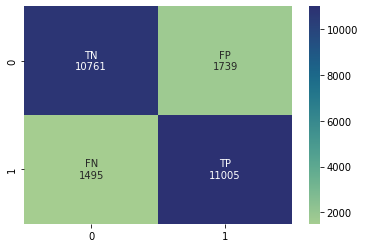

In [ ]:

cnf_matrix = confusion_matrix(fasttest_df['Label'],fasttest_df['predicted'])
total_records = len(fasttest_df)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='crest');

### Motivation: 
As Fast text works on N- Gram approach that is for every sentence is divided into small chunks. The benefit of this model is morpholical inforamtion can be extracted which clearly differentiates the cases like "Pleasant music"(Positive sentiment) to "Unpleasant music" (negative sentiment). The drawback with this approach is as the text n ngrams is increased teh number of featuers will increasing leading to longer training.

Also this is by far best performing model. Well Bert Model was able to reach 93% though

- Note the Bert Model is on next notebook 

# End of the Notebook